<a href="https://colab.research.google.com/github/aarongilman/research/blob/master/fred_inflation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis and Forecast of US Inflation

**We examine inflation data: CPI and PCE, including the core versions, 
along with the 10-year BEI rate (break-even inflation). 
An unified inflation statistic *m4infl* is defined, 
and we make a univariate forecast using the Holt-Winters 
model with optimized robust parameters.
The stochastic characteristics of *m4infl* are
discussed, including its geometric mean rate.**

Appendix 2 presents function `foreinfl()` which concisely 
implements the forecasting process derived in this notebook.

In [ ]:
!pip install --pre fecon236

In [ ]:
from fecon236 import *

In [ ]:
#  PREAMBLE-p6.15.1223d :: Settings and system details
from __future__ import absolute_import, print_function, division
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 !:  Code for this project straddles python27 and python3.
 ::  Python 3.6.8
 ::  IPython None
 ::  jupyter_core None
 ::  notebook None
 ::  matplotlib None
 ::  numpy None
 ::  scipy None
 ::  statsmodels None
 ::  sympy None
 ::  pandas None
 ::  pandas_datareader None
 ::  fecon236 None
 ::  Repository: git_repo_None tag_None branch_None
 ::  Timestamp: 2020-09-16T13:37:09Z
 ::  $pwd: /home/jupyter-aarongilman/inflation/fecon235/nb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Retrieving data

Each economic time series has its own *"fredcode"* which is listed 
at the FRED site, see 
[yi_fred module](https://github.com/rsvp/fecon235/blob/master/lib/yi_fred.py) 
for details.

Let's create a dictionary `ts` of time series in pandas DataFrame 
format from our codelists.

In [ ]:
print(ml_infl)
print(ml_long)

['CPIAUCSL', 'CPILFESL', 'PCEPI', 'PCEPILFE']
['GS10', 'FII10', 'm4spx']


In [ ]:
#  Download updated inflation and bond statistics:
ts = {}
for i in ml_infl + ml_long:
    ts[i] = get(i)

 ::  S&P 500 prepend successfully goes back to 1957.


In [ ]:
#  Collection of historical inflation levels:
tsinf = [ ts[i] for i in ml_infl ]

#  Then make a DataFrame consisting of those levels:
inf_levels = paste( tsinf )
#  ... paste() does a side-by-side mash-up
#  of individual time series.

In [ ]:
#  Label the column names:
inf_levels.columns = ['CPI', 'CPIc', 'PCE', 'PCEc']

In [ ]:
#  Compute year-over-year inflation rates, expressed in percent:
inf = pcent(inf_levels, 12).dropna()
#  since data is monthly ^

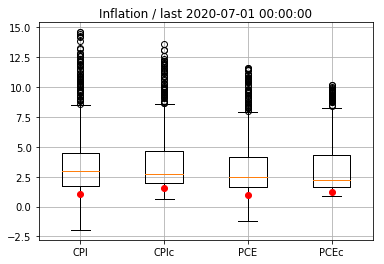

 ::  Stand-by, saving, 140 DPI: img-boxplot-Inflation.png


In [ ]:
boxplot( inf, 'Inflation' )

**The small appended "c" denotes *core* version of headline versions of inflation. 
The red dot represents the most recent data point.**

Our inflation rates go back to **1960-01-01**. 
CPI looks slightly more volatile than PCE versions.

### Re: Consumer Price Index and Personal Consumption Expenditures

> "Two different price indexes are popular for measuring inflation: the consumer price index (CPI) from the Bureau of Labor Statistics and the personal consumption expenditures price index (PCE) from the Bureau of Economic Analysis. [A]n accurate measure of inflation is important for both the U.S. federal government and the Federal Reserve's **Federal Open Market Committee** (FOMC), but they focus on different measures. For example, the federal government uses the CPI to make inflation adjustments to certain kinds of benefits, such as Social Security. In contrast, the **FOMC focuses on PCE inflation in its quarterly economic projections and also states its longer-run inflation goal in terms of headline PCE**. The FOMC focused on CPI inflation prior to 2000 but, after extensive analysis, changed to PCE inflation for three main reasons: The expenditure weights in the PCE can change as people substitute away from some goods and services toward others, the PCE includes more comprehensive coverage of goods and services, and historical PCE data can be revised (more than for seasonal factors only)." --James Bullard, president of the Federal Reserve Bank of St. Louis. 

In [ ]:
stats(inf)

              CPI        CPIc         PCE        PCEc
count  727.000000  727.000000  727.000000  727.000000
mean     3.698789    3.687740    3.248277    3.205297
std      2.828294    2.559234    2.434197    2.149177
min     -1.958761    0.602718   -1.237341    0.902110
25%      1.758568    1.988231    1.603916    1.621224
50%      2.962963    2.699725    2.459607    2.200058
75%      4.480185    4.623574    4.134898    4.286866
max     14.592275   13.604488   11.593359   10.216285

 ::  Index on min:
CPI    2009-07-01
CPIc   2010-10-01
PCE    2009-07-01
PCEc   2010-12-01
dtype: datetime64[ns]

 ::  Index on max:
CPI    1980-03-01
CPIc   1980-06-01
PCE    1980-03-01
PCEc   1975-02-01
dtype: datetime64[ns]

 ::  Head:
                 CPI      CPIc       PCE      PCEc
T                                                 
1960-01-01  1.240951  2.006689  1.692174  2.068512
1960-02-01  1.413793  2.341137  1.703027  2.180406
1960-03-01  1.518813  2.000000  1.689441  2.076496
 ::  Tail:
        

### Unified inflation

The numbers confirm the core version is less volatile than headline inflation. 
Moreover, headline versions are most correlated. 
Note how the dates of the minimum and maximum values do not coincide.

So what is the appropriate inflation rate among the contenders? 
We shall take the *average of the contenders* to arrive at **unified inflation**.

In [ ]:
#  Compute unified inflation:
inf_av = todf(( inf['CPI'] + inf['CPIc'] + inf['PCE'] + inf['PCEc'] ) / 4 )

In [ ]:
stats( inf_av )

                Y
count  727.000000
mean     3.460026
std      2.441337
min     -0.189304
25%      1.734267
50%      2.608131
75%      4.378253
max     12.035391

 ::  Index on min:
Y   2009-07-01
dtype: datetime64[ns]

 ::  Index on max:
Y   1980-03-01
dtype: datetime64[ns]

 ::  Head:
                   Y
T                   
1960-01-01  1.752082
1960-02-01  1.909591
1960-03-01  1.821187
 ::  Tail:
                   Y
T                   
2020-05-01  0.728643
2020-06-01  0.957135
2020-07-01  1.213349

 ::  Correlation matrix:
     Y
Y  1.0


Speaking of unified inflation rates, we can now say 
that the maximum occurred in March 1980 at 12%, 
and that minimum occurred in July 2009 during the 
Great Recession at -0.16% (slight deflation).

In [ ]:
#  The shortest of our time series under consideration, m4tips10, 
#  starts at 2003-01-01, so let
start = '2003-01-01'

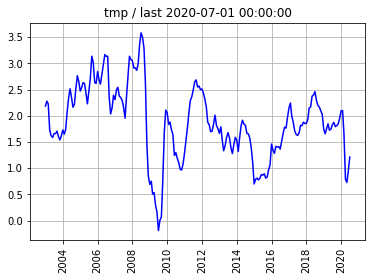

In [ ]:
#  Plot unified inflation, given start:
plot( inf_av[start:] )

We can see the dramatic drop in the unified inflation rate 
during the Great Recession.

## Break-even inflation 

BEI is computed using only data from the bond market. 
The key BEI uses 10-year US government bonds, 
taking the difference in rates between the 
usual on-the-run bond and the TIPS issue. 
TIPS is an abbreviation for "Treasury Inflation Protected Security."

TIPS allow us to observe *real* interest rates
being traded in the market. 
(Notebook https://git.io/gold makes a conjecture 
that real gold prices is a stationary time-series 
bound by real interest rates.) 

In [ ]:
bei = todf( ts[m4bond10] - ts[m4tips10] )

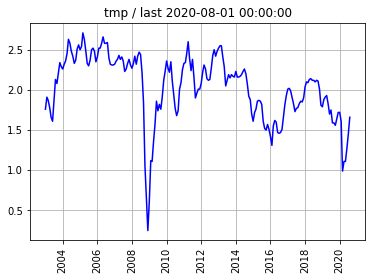

In [ ]:
#  Plot Break-even inflation rate
plot( bei[start:] )

In [ ]:
tail(bei)

               Y
T               
2020-02-01  1.61
2020-03-01  0.99
2020-04-01  1.11
2020-05-01  1.11
2020-06-01  1.27
2020-07-01  1.45
2020-08-01  1.66

Studies comparing forward-looking BEI and realized inflation generally show 
*BEI overestimates realized inflation*. 

What is the correlation between BEI and average inflation? 
Not much. BEI seems to lead unified inflation, cf. circa 2009. 
Also, BEI appears more stable relative to unified inflation.

It is worth emphasizing that 
**unified inflation is a "rear view"** while ***BEI is "forward looking."*** 
Real money bets are made on the spread of the latter. 

#### Present: unified inflation and BEI

Let us mix the rear and forward views equally at arrive at a **"present view"**, 
`bei_inf_av`.

In [ ]:
bei_inf_av = todf((bei + inf_av) / 2) 

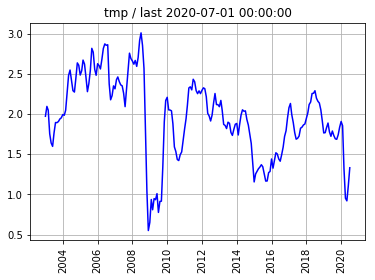

In [ ]:
#  Plot present view:
plot( bei_inf_av[start:] )

In [ ]:
#  Probably the best accessment of current inflation:
tail(bei_inf_av)

                   Y
T                   
2020-01-01  1.907899
2020-02-01  1.854774
2020-03-01  1.321217
2020-04-01  0.952630
2020-05-01  0.919322
2020-06-01  1.113567
2020-07-01  1.331674

Our present inflation measure consisting of 1 part each of 
CPI, CPI core, PCE, PCE core -- plus 4 parts of BEI. 
It does have strong correlation with the Fed's favored inflation measure, 
see Appendix 1.

## Unified inflation *level*

To readily access our findings above in other studies, 
we developed the synthetic pre-fabricated **m4infl** series. 
Each measure of inflation *levels* is first rescaled such that 
the most recent point is equal to 1. 
This eliminates the base year problem and the 
arbitrarily set level of 100 somewhere in time. 
Then we can take the average among inflation levels which 
will be by mathematical construction, *equally weighted*. 
The levels originate from fredcodes: 
`['CPIAUCSL', 'CPILFESL', 'PCEPI', 'PCEPILFE']`.

As a very convenient by-product, the recipricol of m4infl 
yields *multiplicative factors useful for deflating prices*, see **m4defl**.

(API note: The average between backward and forward-looking inflation *rates* 
is codified as **m4inflbei**.)

In [ ]:
infl = get(m4infl)

#  m4infl represents unified inflation level, synthesized
#  from four different US government time-series.

In [ ]:
#  Latest levels of unified inflation:
tail(infl)

                   Y
T                   
2020-01-01  0.995411
2020-02-01  0.996782
2020-03-01  0.994564
2020-04-01  0.988999
2020-05-01  0.989468
2020-06-01  0.993461
2020-07-01  0.998118

In [ ]:
#  From the level, we compute annual rates:
inflrate = pcent(infl, 12)

In [ ]:
#  VERIFY if our two methods agree, by linear regression:
stat2( inf_av['Y'], inflrate['Y'] )
#  (Think of this as an unit test, visible in a notebook.)
#  'Y' is the default column label.

 ::  FIRST variable:
count    727.000000
mean       3.460026
std        2.441337
min       -0.189304
25%        1.734267
50%        2.608131
75%        4.378253
max       12.035391
Name: Y, dtype: float64

 ::  SECOND variable:
count    727.000000
mean       3.442063
std        2.418909
min       -0.217823
25%        1.734721
50%        2.598858
75%        4.363663
max       11.889298
Name: Y, dtype: float64

 ::  CORRELATION
0.9999558152481136
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.204e+06
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:37:16   Log-Likelihood:                 1713.0
No. Observations:                 727   AIC:                            -3422

The result shows perfect correlation since 1960 (full dataset), 
thus our synthetic series **m4infl** works as intended.

### Geometric mean rate of unified inflation

The level form of unified inflation allows us to 
directly use the tools developed for financial assets.

In [ ]:
gemrat(infl[start:], yearly=12)

[1.830957266081179,
 1.8323541358954774,
 0.5333431197431664,
 10.291349842366099,
 12,
 210]

The geometric mean rate of unified inflation is 1.83% 
since `start`, the volatility is 0.53%, 
thus a 50 basis point move in a year would not be surprising. 
The most interesting statistic reveals that *inflation is leptokurtotic*.

## Holt-Winters forecast for inflation

For predicting inflation, it is preferable to use levels, rather than rates, 
as primary form of time-series due to linearity considerations 
(see plot in the next cell).

Forecasting will be covered in detail in another notebook. 
But here we demonstrate the **Holt-Winters model**.

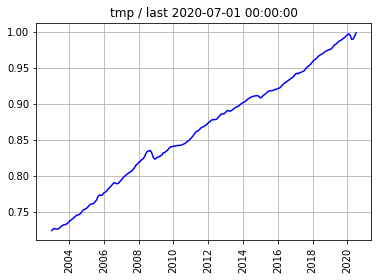

In [ ]:
#  Visualize unified inflation levels:
plot(infl[start:])

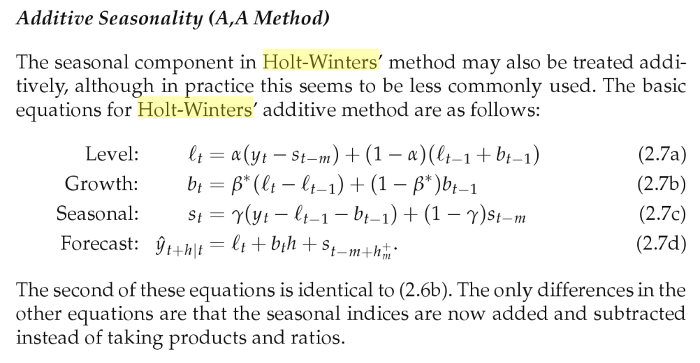

In [ ]:
Image(filename='holt-winters-equations.png', embed=True)

We can safely ignore the seasonal portion of the model 
since the relevant data has been deseasonalized at the upstream source.

Two important parameters, $\alpha$ and $\beta$, must estimated. 
We developed a robust L1 estimation technique which 
minimizes one-step ahead forecast errors, 
conditional on specific data. See 
[ys_opt_holt module](https://github.com/rsvp/fecon235/blob/master/lib/ys_opt_holt.py) 
for details.

In [ ]:
#  This optimization procedure may be computationally intense, 
#  depending on data size and the number of grids.
from fecon236.tsa.holtwinters import optimize_holt
ab = optimize_holt( infl, grids=50 )

ab

 !.  WARNING: ipykernel_launcher.py Optimizing Holt-Winters alphabetaloss may take TIME!


[1.0, 0.4082, 0.0303, 0.00030252114508022565]

The first two elements in the `ab` list are $\alpha$ and $\beta$ respectively. 
The third element gives the median absolute loss as percent for an 
one-step ahead forecast given those parameters. 
The fourth element is the median absolute loss 
(due to our L1 loss function for robust optimization).

The median absolute loss is 0.00031 
which gives us confidence that the model has performed well.

Using the estimated parameters, we can now proceed to 
generate our 12-step ahead forecast.

In [ ]:
from fecon236.tsa.holtwinters import holtforecast, holt

holtdf = holt( infl, alpha=ab[0], beta=ab[1] )
holtforecast( holtdf, h=12 )

    Forecast
0   0.998118
1   1.000584
2   1.003050
3   1.005516
4   1.007981
5   1.010447
6   1.012913
7   1.015379
8   1.017845
9   1.020311
10  1.022777
11  1.025243
12  1.027709

Since the most current level of unified inflation 
is 1.00 by construction, it is easy to discern that: 
***the 12-months ahead forecast implies an annualized inflation rate of 2.78%.***

## Forecasting summary

Forecasting is an art. 
A pearl of wisdom is to combine orthogonal methods 
to arrive at excellence.

Here are three non-related ways which characterized inflation:

- BEI, Break-even Inflation: a long-term forecast implied by the bond market
- Geometric mean rate: internal growth rate of a stochastic trend
- Holt-Winters model: projection obtained by robust prediction error minimization

The respective results are simply averaged...

In [ ]:
( 1.33 + 1.83 + 2.78 ) / 3

1.9799999999999998

There are many sorts of inflation measures, 
but we devised a mathematically unified version. 
The bond market has its own version, 
so for the **one-year ahead forecast**, 
all in all, we shall settle for:
**1.98%**.

---

## Appendix 1:  Overall Correlations

In [ ]:
#  Conversions to dataframe with label before paste:
dfa = todf( inf_av, 'Iav')
dfb = todf( bei, 'BEI' )
dfc = todf( bei_inf_av, 'BEI_Iav')

In [ ]:
#  Mother of all annualized inflation rates:
infall = paste( [inf, dfa, dfb, dfc] )

In [ ]:
#  CORRELATION matrix going back to 2003-01-01 (start of BEI):
cormatrix(infall)

              CPI      CPIc       PCE      PCEc       Iav       BEI   BEI_Iav
CPI      1.000000  0.403975  0.988748  0.763334  0.975121  0.596305  0.925095
CPIc     0.403975  1.000000  0.363323  0.753368  0.570935  0.141022  0.455942
PCE      0.988748  0.363323  1.000000  0.794651  0.971954  0.644729  0.942829
PCEc     0.763334  0.753368  0.794651  1.000000  0.884079  0.565973  0.849159
Iav      0.975121  0.570935  0.971954  0.884079  1.000000  0.600728  0.944254
BEI      0.596305  0.141022  0.644729  0.565973  0.600728  1.000000  0.830435
BEI_Iav  0.925095  0.455942  0.942829  0.849159  0.944254  0.830435  1.000000

CPI and PCE are tightly correlated, as are CPIc and PCEc. 
Surprisingly, CPI and CPIc are only moderately correlated, only 40%. 
Recall that headline inflation includes food and energy, 
whereas core inflation excludes those components.

The market traded BEI break-even inflation is modestly correlated 
with government-released statistics of inflation.

#### Most recent computed data

Given in annualized percentage form:

In [ ]:
#  Inflation RATES
tail(infall, n=12)

                 CPI      CPIc       PCE      PCEc       Iav   BEI   BEI_Iav
T                                                                           
2019-08-01  1.742323  2.369558  1.522164  1.865451  1.874874  1.59  1.732437
2019-09-01  1.717269  2.349520  1.385962  1.721905  1.793664  1.59  1.691832
2019-10-01  1.761236  2.314348  1.434532  1.737116  1.811808  1.56  1.685904
2019-11-01  2.043046  2.317256  1.439946  1.584707  1.846239  1.64  1.743119
2019-12-01  2.292076  2.248583  1.644670  1.621393  1.951681  1.72  1.835840
2020-01-01  2.482677  2.268139  1.878353  1.754022  2.095798  1.72  1.907899
2020-02-01  2.318104  2.365675  1.844903  1.869512  2.099549  1.61  1.854774
2020-03-01  1.518330  2.096304  1.340937  1.654164  1.652434  0.99  1.321217
2020-04-01  0.376163  1.438310  0.457992  0.908577  0.795260  1.11  0.952630
2020-05-01  0.235532  1.236465  0.490339  0.952236  0.728643  1.11  0.919322
2020-06-01  0.709470  1.194257  0.857541  1.067272  0.957135  1.27  1.113567

## Appendix 2: Forecasting process as a function

We can think of this notebook as the documentation 
which encapsulates its findings and process 
into a single function: `foreinfl()`.

In [ ]:
#  Query into its details:
foreinfl??

Signature: foreinfl(n=120, alpha=1.0, beta=0.3673)
Source:   
def foreinfl(n=120, alpha=1.0, beta=0.3673):
    '''Forecast Unified Inflation 1-year ahead per https://git.io/infl
       which a rendering of fecon235/nb/fred-inflation.ipynb.
       SUMMARY output: [Average, "infl-date", GMR, HW, BEI]
       e.g.  [2.2528, '2018-01-01', 1.5793, 3.0791, 2.1000]
       where Average is the mean of three orthogonal methods:
       GMR for geometric mean rate, HW for Holt-Winters time-series,
       and BEI for Break-even Inflation from the Treasury bond market.
       Default n denotes 120-month history, i.e. last 10 years.
    '''
    #  Holt-Winters parameters alpha and beta are optimized
    #  from the 1960-2018 dataset, consisting of 697 monthly points.
    #  Each "way" is an orthogonal method, to be averaged into way[0].
    way = [-9, -9, -9, -9, -9]  # dummy placeholders.
    inflall = get(m4infl)       # synthetic Unified Inflation, monthly.
    infl = tail(inflall, n)
    way[1] =

In [ ]:
#  See it in action:
foreinfl()

[1.941973346614384,
 '2020-07-01',
 1.6893430973556,
 2.4765769424875517,
 1.6600000000000001]

There are slight variations from the notebook derivation.

- Instead of `start` we use a rolling window of `n` monthly datapoints.
- By default, `n` is set to 120, i.e. the last ten years.
- Given new data, we do not re-optimize the Holt-Winters parameters, since that would be computationally expensive. The default values for alpha and beta are battle-tested using data dating back to 1960.
- Bond market data does not suffer from release lag, unlike inflation statistics, so the most *current* BEI is used in the `foreinfl()` function.

To obtain an inflation forecast in practice, 
executing a single Python function is far more convenient 
than re-running a Jupyter notebook. 
The list output also gives a summary from the orthogonal methods 
which were utilized.